In [33]:
import simulation
import numpy as np
from scipy.stats import halfnorm

b = 2.0            # birth rate
d = 1           # intrinsic death rate
dprime = 0.1       # competition rate
lam = 1          # initial density (individuals per unit length)


L = 10.0
M = 1

epsilon = 1e-3
N=1001

sigma_m = 1.0      # std. of dispersal (birth) kernel
sigma_w = 0.1     # std. of competition kernel

uvals = np.linspace(0, 1 - epsilon, N)
rvals = halfnorm.ppf(uvals, scale=sigma_m)

birthX_1d = [uvals.tolist()]  # single species
birthY_1d = [rvals.tolist()]

import numpy as np

def normal_1d_kernel(r, sigma=1.0):
    # Approximates the correct factor for 3D normalization
    c = 1 / (2 * np.pi * sigma**2)**(1/2)
    return c * np.exp(-0.5*(r**2)/(sigma**2))

max_r = 5*sigma_w
distances = np.linspace(0, max_r, N)
values = [normal_1d_kernel(r, sigma=sigma_w) for r in distances]

deathX_1d = [[ distances.tolist() ]]
deathY_1d = [[ values ]]
cutoffs = [max_r]

g1 = simulation.PyGrid1(
    M=M,
    areaLen=[L],
    cellCount=[L],
    isPeriodic=True,
    birthRates=[b],
    deathRates=[d],
    ddMatrix=[dprime],    # 1x1 for single species
    birthX=birthX_1d,     # example
    birthY=birthY_1d,
    deathX_=deathX_1d,
    deathY_=deathY_1d,
    cutoffs=cutoffs,
    seed=42,
    rtimeLimit=7200.0
)


# Parameters
N = 1000  # Number of [x, y] pairs per group

# Generate the list
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(N)]
    coordinates.append(group)

g1.placePopulation(coordinates)

print("Birth rate:", g1.total_birth_rate)
print("Death rate:", g1.total_death_rate)

Birth rate: 2000.0
Death rate: 2006.006409731446


In [46]:
g1.run_for(10)
coords = []
for i in range(100):
    coords.append(g1.get_all_particle_coords()[0])
    g1.run_for(1)

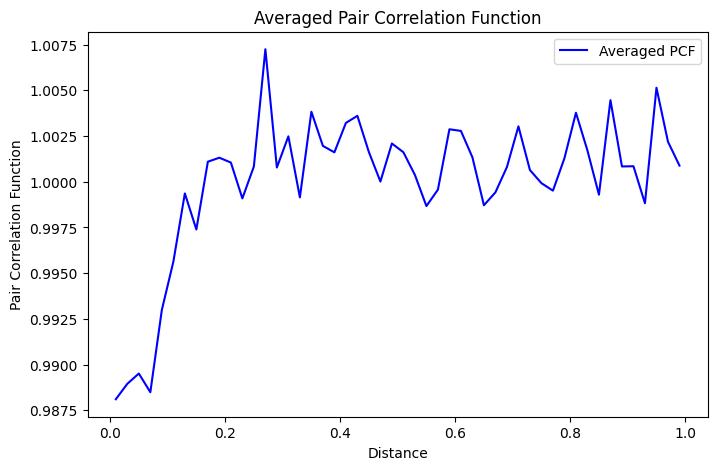

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pcf(coords, L, bins=50):
    """Compute the pair correlation function for 1D periodic coordinates."""
    coords = np.array(coords)
    n = len(coords)
    dists = []

    # Compute pairwise distances with periodic boundary conditions
    for i in range(n):
        for j in range(i + 1, n):
            d = abs(coords[i] - coords[j])
            d = min(d, L - d)  # Periodic condition
            dists.append(d)

    dists = np.array(dists)

    # Compute histogram of distances
    hist, edges = np.histogram(dists, bins=bins, range=(0, L/10), density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    return bin_centers, hist

def average_pcf(coord_lists, L, bins=50):
    """Compute the averaged PCF over multiple lists of coordinates."""
    all_histograms = []
    bin_centers = None

    for coords in coord_lists:
        centers, hist = compute_pcf(coords, L, bins)
        all_histograms.append(hist)
        if bin_centers is None:
            bin_centers = centers

    # Compute mean and standard deviation across lists
    mean_hist = np.mean(all_histograms, axis=0)
    std_hist = np.std(all_histograms, axis=0)

    return bin_centers, mean_hist, std_hist

def plot_pcf(bin_centers, mean_hist, std_hist):
    """Plot the averaged pair correlation function with error bars."""
    plt.figure(figsize=(8, 5))
    plt.plot(bin_centers, mean_hist, label='Averaged PCF', color='b')
    plt.xlabel('Distance')
    plt.ylabel('Pair Correlation Function')
    plt.title('Averaged Pair Correlation Function')
    plt.legend()
    plt.show()

bin_centers, mean_hist, std_hist = average_pcf(coords, L)
plot_pcf(bin_centers, mean_hist, std_hist)

In [53]:
np.mean([len(x) for x in coords])/L

np.float64(99.934)